In [4]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
#sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [5]:
# This is needed to display the images.
%matplotlib inline

In [6]:
from object_detection.utils import label_map_util

In [7]:
from object_detection.utils import visualization_utils as vis_util

In [8]:
# What model to download.
MODEL_NAME = 'rfcn_resnet101_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(
    'object_detection',
    'data',
    'mscoco_label_map.pbtxt'
)

In [9]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [10]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0812 10:00:53.702153 4737811904 deprecation_wrapper.py:119] From /Users/fred.shone/Projects/cam/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [12]:
def load_image_into_numpy_array(image):
    (im_width, im_height, _) = image.shape
    
    return image.astype(np.uint8)

#     return np.array(image).reshape(
#         (im_height, im_width, 3)).astype(np.uint8)

In [13]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'data/img1'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, f"{str(i).zfill(6)}.jpg".format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [14]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
            
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            
            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})
            
            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
                
        return output_dict

In [23]:
vidcap = cv2.VideoCapture(os.path.join('data','north_trim','north_trim.mp4'))
success = True
count = 0
output_path = os.path.join('data','north_trim', 'sample1','det','det.txt')

In [24]:

while success:
    success,image = vidcap.read()
    
    count += 1
    print('Read a new frame: ', success, count)

    #image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_np = load_image_into_numpy_array(image)
        
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

    # Collect results in correct format for MOT
    if output_dict:
        num_detections = output_dict['num_detections']
        if not num_detections:
            print('No detections')
        if num_detections:
            detection_classes = output_dict['detection_classes']
            detection_scores = output_dict['detection_scores']

            # mask for peds and threshold > 90
            mask = (detection_classes == 1) & (detection_scores >= .9)
            detection_boxes = output_dict['detection_boxes'][mask]
            detection_scores = detection_scores[mask]
            print('{} detections'.format(len(detection_scores)))


            height, width = image_np.shape[:2]
            
            with open(output_path, 'a') as file_out:
                for counter, (detection, conf) in enumerate(zip(detection_boxes, detection_scores)):
                    y_min, x_min, y_max, x_max = detection
                    bb_top = int(y_min * height)
                    bb_left = int(x_min * width)
                    bb_height = int((y_max * height) - bb_top)
                    bb_width = int((x_max * width) - bb_left)

                    ####### left top width height
                    result = count, -1, bb_left, bb_top, bb_width, bb_height, conf, -1, -1, -1
                    result_str = ','.join((str(r) for r in result))
                    #print(' Detection: {}'.format(result_str))
                    file_out.write(result_str + '\n')

#         # Visualization of the results of a detection.
#         vis_util.visualize_boxes_and_labels_on_image_array(
#             image_np,
#             output_dict['detection_boxes'],
#             output_dict['detection_classes'],
#             output_dict['detection_scores'],
#             category_index,
#             instance_masks=output_dict.get('detection_masks'),
#             use_normalized_coordinates=True,
#             line_thickness=8)
#         plt.figure(figsize=IMAGE_SIZE)
#         plt.imshow(image_np)

Read a new frame:  True 1
8 detections
Read a new frame:  True 2
8 detections
Read a new frame:  True 3
8 detections
Read a new frame:  True 4
9 detections
Read a new frame:  True 5
7 detections
Read a new frame:  True 6
6 detections
Read a new frame:  True 7
8 detections
Read a new frame:  True 8
7 detections
Read a new frame:  True 9
7 detections
Read a new frame:  True 10
6 detections
Read a new frame:  True 11
8 detections
Read a new frame:  True 12
7 detections
Read a new frame:  True 13
9 detections
Read a new frame:  True 14
8 detections
Read a new frame:  True 15
7 detections
Read a new frame:  True 16
7 detections
Read a new frame:  True 17
8 detections
Read a new frame:  True 18
8 detections
Read a new frame:  True 19
9 detections
Read a new frame:  True 20
8 detections
Read a new frame:  True 21
9 detections
Read a new frame:  True 22
9 detections
Read a new frame:  True 23
8 detections
Read a new frame:  True 24
6 detections
Read a new frame:  True 25
6 detections
Read a ne

8 detections
Read a new frame:  True 204
7 detections
Read a new frame:  True 205
7 detections
Read a new frame:  True 206
7 detections
Read a new frame:  True 207
7 detections
Read a new frame:  True 208
7 detections
Read a new frame:  True 209
7 detections
Read a new frame:  True 210
8 detections
Read a new frame:  True 211
8 detections
Read a new frame:  True 212
8 detections
Read a new frame:  True 213
8 detections
Read a new frame:  True 214
8 detections
Read a new frame:  True 215
8 detections
Read a new frame:  True 216
8 detections
Read a new frame:  True 217
8 detections
Read a new frame:  True 218
8 detections
Read a new frame:  True 219
8 detections
Read a new frame:  True 220
8 detections
Read a new frame:  True 221
7 detections
Read a new frame:  True 222
6 detections
Read a new frame:  True 223
7 detections
Read a new frame:  True 224
7 detections
Read a new frame:  True 225
7 detections
Read a new frame:  True 226
7 detections
Read a new frame:  True 227
8 detections
Rea

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [25]:
import PIL.Image as Image
from PIL import ImageFont
from PIL import ImageDraw
import numpy as np
# This is needed to display the images.
%matplotlib inline

In [26]:
def load_detections(path):
    return np.loadtxt(path, delimiter=',')

In [27]:
def test_bbox(detections_path, image_path, frame_num):

    # get detections
    dets = load_detections(detections_path)

    print(f"loading: {image_path}")
    image = Image.open(image_path).convert("RGB")

    draw = ImageDraw.Draw(image)

    frame_dets = dets[dets[:,0] == frame_num]
    for det in frame_dets:
        left,top,width,height = det[2:6]
        bottom = top + height
        right = left + width
        centre = left + (width/2)

        draw.line(
            [
                (left, top),
                (left, bottom),
                (right, bottom),
                (right, top),
                (left, top)
            ],
            width=3,
            fill='red'
        )
        draw.ellipse(
            [
                (centre-5, bottom-5),
                (centre+5, bottom+5)
            ],
            fill='yellow',
        )


    plt.figure(figsize=(10,10))
    plt.imshow(image)


In [30]:
detections_path = os.path.join('data', 'north_trim', 'sample1', 'det', 'det.txt')
images_path = os.path.join('data', 'north_trim', 'sample1', 'img1')
image_path = os.path.join(images_path, '000001.jpg')

loading: data/north_trim/sample1/img1/000001.jpg


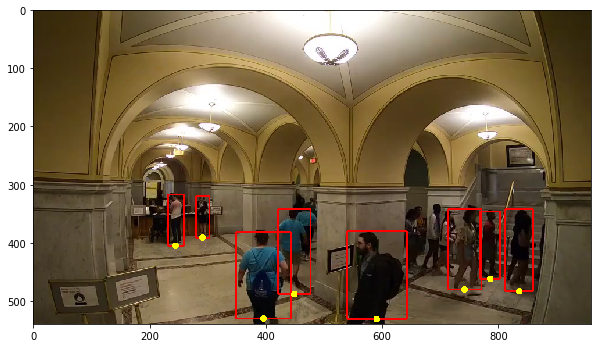

In [31]:
test_bbox(detections_path, image_path, 1)

In [36]:
detections_path = os.path.join('data', 'north_trim', 'sample1', 'det', 'det.txt')
images_path = os.path.join('data', 'north_trim', 'sample1', 'img1')
image_path = os.path.join(images_path, '000010.jpg')

loading: data/north_trim/sample1/img1/000010.jpg


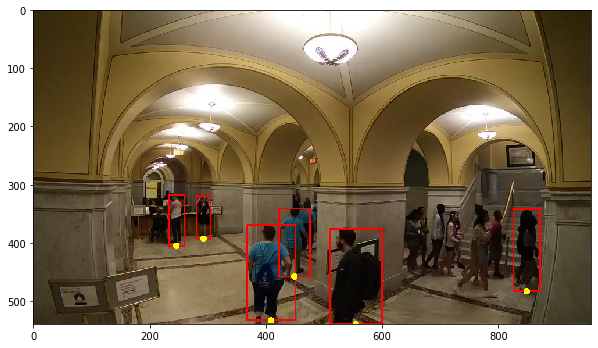

In [37]:
test_bbox(detections_path, image_path, 10)

In [38]:
# # define as clockwide around INSIDE direction
# point_a = (30,300)
# point_b = (480,240)
# point_c = (730,380)
# top_trigger = [point_a, point_b]
# right_trigger = [point_b, point_c]
# bottom_trigger = [point_c, point_a]

In [74]:
# define as clockwide around INSIDE direction
point_a = (320,360)
point_b = (550,500)
point_c = (720,400)
point_d = (900, 420)
left_trigger = [point_a, point_b]
right_trigger = [point_b, point_c]
stair_trigger = [point_c, point_d]

In [75]:
def test_trigger(trigger, image):
    
    draw = ImageDraw.Draw(image)

    draw.line(
        trigger,
        width=3,
        fill=next(get_colour())
    )
       


In [76]:
def convert_to_rgb(cmap):
    r, g, b = [str(int(c * 255)) for c in cmap[:3]]
    return f'rgb({r}, {g}, {b})'

def get_colour(size=20):  
    cmap = plt.cm.get_cmap('tab20', size)
    index = np.random.choice(list(range(size)), size=size, replace=False, p=None)
    while True:
        for i in index:
            yield convert_to_rgb(cmap(i))

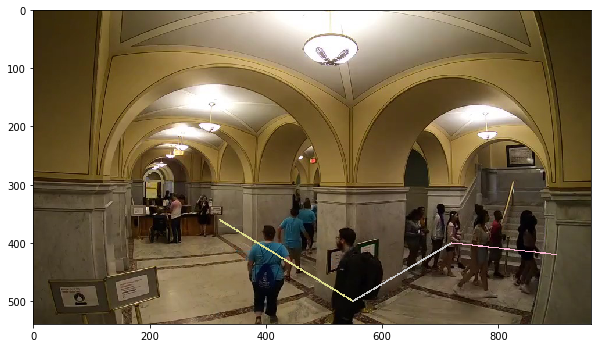

In [77]:
image = Image.open(image_path).convert("RGB")
test_trigger(left_trigger, image)
test_trigger(right_trigger, image)
test_trigger(stair_trigger, image)
plt.figure(figsize=(10,10))
plt.imshow(image)

In [ ]:
p = Point((11,0))
line_a.

In [ ]:
cv2.polylines(
np.array(image),
[np.array([[0,0],[1,1]])],
False,
'black',
2
)

In [ ]:
if None:
    print('f')

In [ ]:
from shapely.geometry import Point, LineString
from matplotlib.animation import FuncAnimation

In [ ]:
from collections import OrderedDict
class MyOrderedDict(OrderedDict):
    def last(self):
        k = next(reversed(self))
        return k, self[k]
    def last2(self):
        k = list(self.keys())[-2]
        return k, self[k]

In [ ]:
d = MyOrderedDict()
d[1] = 1
d[2] = 2
d[3] = 3
d[4] = 1

In [ ]:
[p for p in d.values()]

In [ ]:
class Agent:
    
    bb = None
    loc = None
    l_loc = None
    time = None
    time_traj = []
    trajectory = MyOrderedDict()
    # {t: point}
    
    speed = None
    direction = None
    total_dist = 0
    
    
    def __init__(self, ident, color):
        self.ident = ident
        self.color = color
        
    def add_detection(self, bb, t):
        ####### left top width height
        l,t,w,h = bb
        
        self.bb = bb
        self.loc = Point((int(l + w/2), int(t + h)))
        self.time = t
        self.time_traj.append(t)
        self.trajectory[t] = self.loc
        
        if len(self.time_traj) > 1:
            self.build_trace(t)
            
    def build_trace(self, t):
        t_, loc_ = self.trajectory.last2()
        t_diff = t - t_
        dist = self.loc.distance(loc_)
        
        self.speed = dist / t_diff
        self.direction = (self.loc.x - loc_.x), (self.loc.y - loc_.y)
        self.total_dist += dist   
        
    def add_bb(self, draw):
        ####### left top width height
        left, top, width, height = self.bb
        right = left + width
        bottom = top + height
        
        draw.line(
            [
                (left, top),
                (left, bottom),
                (right, bottom),
                (right, top),
                (left, top)
            ],
            width=3,
            fill=self.color
        )
    
    def add_point(self, draw):
        ####### left top width height
        left, top, width, height = self.bb
        centre = left + width/2
        bottom = top + height
        
        draw.ellipse(
            [
                (centre-5, bottom-5),
                (centre+5, bottom+5)
            ],
            fill=self.color
        )
            
    def add_traj(self, draw):
        
        traj = [(p.x, p.y) for p in self.trajectory.values()]
        draw.line(
            traj,
            width=3,
            fill=self.color
        )
         
        
def distance_between(p1, p2):
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    return 
        
        
        

In [ ]:
def get_num(string):
    return int(''.join(s for s in string if s.isdigit()))

In [ ]:
agents = {}

detections_path = os.path.join('data', 'sample', 'tracks.txt')
images_path = os.path.join('data', 'sample', 'img1')

image_names = [n for n in os.listdir(images_path) if n[-4:] == ".jpg"]
image_names = sorted(image_names)

f = plt.figure(figsize=(10,10))
ax = f.gca()

image = Image.open(os.path.join(images_path, image_names[0])).convert("RGB")
p = plt.imshow(image, animated=True)

colours = get_colour()

# get detections
detections = load_detections(detections_path)

for img_name in image_names:
    image_path = os.path.join(images_path, img_name)

    frame = get_num(img_name)

    frame_dets = detections[detections[:,0] == frame]

    image = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(10,10))

    for det in frame_dets:
        frame = det[0]
        ident = det[1]
        bb = det[2:6]

        if not agents.get(ident):
            agents[ident] = Agent(ident, next(colours))

        agents[ident].add_detection(bb, frame)

        draw = ImageDraw.Draw(image)

        agents[ident].add_bb(draw)
        agents[ident].add_traj(draw)
        agents[ident].add_point(draw)
    
    p.set_data(image)
        


In [ ]:
for a in d.values():
    print(a)

In [ ]:
[(p.x, p.y) for p in d.values()]

In [ ]:
p1.distance(p2)

In [ ]:
p2.distance(p1)